<a href="https://colab.research.google.com/github/Lizzie1234567/aml-elliptic-gnn/blob/main/%E2%80%9CEliptic_tracker_ML_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anti Money Laundering in Elliptic Blockchain dataset

Project outline

*   Implement the paper
*   Change architectures from Torch to Keras
*   Develop the tracking algorithm
*   Develop a GAT model and compare it to the GCN
*   Compare all the results


## Prepare and inspect data

### imports

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn

### data retrival

In [2]:
# Prepare a dataFrame for results, used in the last part for a general comparison
compare = pd.DataFrame(columns=['model','Precision','Recall', 'F1 Score','M.A F1 Score'])

In [3]:
# os.environ['KAGGLE_USERNAME'] = "lizzylin067@gmail.com" # username from the json file
# os.environ['KAGGLE_KEY'] = "Kaggle067!" # key from the json file


# !kaggle datasets download -d ellipticco/elliptic-data-set
# !unzip elliptic-data-set.zip
# !mkdir elliptic_bitcoin_dataset_cont

import os

os.environ['KAGGLE_USERNAME'] = "henry067"
os.environ['KAGGLE_KEY'] = "0d6098f677227f95b88639d89e049217"

!kaggle datasets download -d ellipticco/elliptic-data-set

# Unzip the file if it exists
if os.path.exists("elliptic-data-set.zip"):
    !unzip elliptic-data-set.zip

# Create the directory if it doesn't exist
if not os.path.exists("elliptic_bitcoin_dataset_cont"):
    os.makedirs("elliptic_bitcoin_dataset_cont")

 99% 144M/146M [00:01<00:00, 118MB/s]
100% 146M/146M [00:01<00:00, 105MB/s]
Archive:  elliptic-data-set.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  


In [4]:
edges = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_classes.csv")

In [5]:
print(edges.shape)
print(features.shape)
print(classes.shape)

(234355, 2)
(203769, 167)
(203769, 2)


### data preparation

In [6]:
#name all the features
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features

#merge features and classes
features = pd.merge(features,classes,left_on="txId",right_on="txId",how='left')
features['class'] = features['class'].apply(lambda x: 0 if x == "unknown" else x)
features['class'] = features['class'].apply(lambda x: 1 if x == '1' else x)
features['class'] = features['class'].apply(lambda x: 2 if x == '2' else x)

<Axes: >

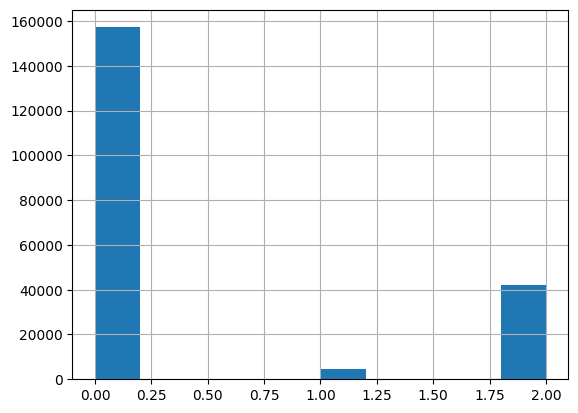

In [7]:
features['class'].hist()

### swap the index
for easier of use, we change the TxId identifier for the integer index. This simply many of the following considerations

In [8]:
class_values = sorted(features["class"].unique())
#we create a new index by sorting the tx_ids and assign to it a number
features_idx = {name: idx for idx, name in enumerate(sorted(features["txId"].unique()))}

# we then apply this new ids to all te data frames
# this helps a lot in computing the adjency matrix, having the ids as the index.
features["txId"] = features["txId"].apply(lambda name: features_idx[name])
edges["txId1"] = edges["txId1"].apply(lambda name: features_idx[name])
edges["txId2"] = edges["txId2"].apply(lambda name: features_idx[name])

## The tracker
The tracker is a function thats able to build the connected graph of a given transaction, displaying the graph, and compare it to the classified one.
It can be used to look for particular clusters, for example the biggest connected graph, or it can be used to track a specific transaction.

### the tracking function

In [9]:
# The tracker function recursively scans the network looking for the connected group to a given transaction.
# the deep levels represent the amount of recursive iterations it computes

def tracker(deep_levels, seed, edges):
  tmp = {seed}
  keep = set()
  counter = 0

  for i in range(deep_levels):
    for j in tmp:
      counter = counter + 1
      one = edges[edges['txId1'] == j]
      #add first
      tmp = set.union(tmp,set(one['txId2'].iloc[:]))

      two = edges[edges['txId2'] == j]
      #add second
      tmp = set.union(tmp,set(two['txId1'].iloc[:]))
      # check if connected group is empty
      if(len(one) == 0 & len(two) == 0):
          edgeList = edges[edges['txId1'].isin(keep)]
          return keep,edgeList,counter,True

      keep.add(j)
      tmp.remove(j)

  edgeList = edges[edges['txId1'].isin(keep)]
  return keep,edgeList,counter,False

In [10]:
def get_random_illicit(features):
  # get a random illicit transaction
  randomIllicit = features[features["class"] == 1].sample(1)["txId"]
  seed = randomIllicit.to_numpy()[0]
  # define the final DF containg the cluster
  return seed

In [11]:
def get_random_licit(features):
  # get a random illicit transaction
  randomLicit = features[features["class"] == 2].sample(1)["txId"]
  seed = randomLicit.to_numpy()[0]
  # define the final DF containg the cluster
  return seed

### Plot an example graph

## Classification

### select only the known part

In [12]:
# helper function
def check(name):
  if(name in unique):
    return name
  else :
    return -1

In [13]:
# get the features of the known transactions
features_known = features[features['class'] != 0 ]
features_unknown = features[features['class'] == 0 ]
edges_known = edges.copy()

# remove from the edges DF all the entries that mentions the unknown transactions
unique = features_known['txId'].unique()
edges_known["txId1"] = edges["txId1"].apply(lambda name: check(name))
edges_known["txId2"] = edges["txId2"].apply(lambda name: check(name))

edges_known = edges_known[edges_known["txId1"] != -1 ]
edges_known = edges_known[edges_known["txId2"] != -1 ]

print(edges_known.shape)
print(features.shape)
print(features_known.shape)
print(features_unknown.shape)

(36624, 2)
(203769, 168)
(46564, 168)
(157205, 168)


### split the data in train and test

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier

In [15]:
#Split the data, with the aggregated features

X = features_known[tx_features+agg_features]
y = features_known['class']
# this is important
y = y.apply(lambda x: 0 if x == 2 else 1 )
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=117,shuffle=True)
print("X_train shape",X_train.shape)
print("X_test shape",X_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)

X_train shape (32594, 165)
X_test shape (13970, 165)
y_train shape (32594,)
y_test shape (13970,)


In [16]:
#Split the data, without the aggregated features

X_noAgg = features_known[tx_features]
y_noAgg = features_known['class']
# this is important
y_noAgg = y_noAgg.apply(lambda x: 0 if x == 2 else 1 )
X_train_noAgg, X_test_noAgg, y_train_noAgg, y_test_noAgg = train_test_split(X_noAgg,y_noAgg,test_size=0.3,random_state=117,shuffle=True)
print("X_train shape",X_train_noAgg.shape)
print("X_test shape",X_test_noAgg.shape)
print("y_train shape",y_train_noAgg.shape)
print("y_test shape",y_test_noAgg.shape)

X_train shape (32594, 93)
X_test shape (13970, 93)
y_train shape (32594,)
y_test shape (13970,)


### Classification with Random Forest and Logistic Regression

The classification is done for both classifiers with and without aggregated features

In [17]:
clf = RandomForestClassifier(n_estimators=50, max_depth=100,random_state=15).fit(X_train_noAgg,y_train_noAgg)
preds = clf.predict(X_test_noAgg)
prec,rec,f1,num = precision_recall_fscore_support(y_test_noAgg,preds, average=None)
name = "Random Forest Classifier (tx)"
print(name)
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test_noAgg,preds,average='micro')
print("Micro-Average F1 Score:",np.round(micro_f1,3))

Random Forest Classifier (tx)
Precision:0.981 
Recall:0.854 
F1 Score:0.913
Micro-Average F1 Score: 0.985


In [18]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-18-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [19]:
clf = RandomForestClassifier(n_estimators=50, max_depth=100,random_state=15).fit(X_train,y_train)
preds = clf.predict(X_test)
prec,rec,f1,num = precision_recall_fscore_support(y_test,preds, average=None)
name = "Random Forest Classifier (tx + agg)"
print("Random Forest Classifier (tx + agg)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

Random Forest Classifier (tx + agg)
Precision:0.994 
Recall:0.888 
F1 Score:0.938
Micro-Average F1 Score: 0.988976377952756


In [20]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-20-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [21]:
reg = LogisticRegression(max_iter=10000).fit(X_train_noAgg,y_train_noAgg)
preds = reg.predict(X_test_noAgg)
prec,rec,f1,num = precision_recall_fscore_support(y_test_noAgg,preds, average=None)
name = "Logistic Regression (tx)"
print("Logistic Regression (tx)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test_noAgg,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

Logistic Regression (tx)
Precision:0.910 
Recall:0.725 
F1 Score:0.807
Micro-Average F1 Score: 0.9672870436649964


In [22]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-22-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [23]:
reg = LogisticRegression(max_iter=10000).fit(X_train,y_train)
preds = reg.predict(X_test)
prec,rec,f1,num = precision_recall_fscore_support(y_test,preds, average=None)
name = "Logistic Regression (tx + agg)"
print("Logistic Regression (tx + agg)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

Logistic Regression (tx + agg)
Precision:0.848 
Recall:0.791 
F1 Score:0.819
Micro-Average F1 Score: 0.9669291338582677


In [24]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-24-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [25]:
mlp = MLPClassifier(alpha=1, max_iter=1000).fit(X=X_train_noAgg,y=y_train_noAgg)
preds = mlp.predict(X_test_noAgg)
prec,rec,f1,num = precision_recall_fscore_support(y_test_noAgg,preds, average=None)
name = "MLP (tx)"
print("MLP (tx)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

MLP (tx)
Precision:0.883 
Recall:0.752 
F1 Score:0.813
Micro-Average F1 Score: 0.9672870436649964


In [26]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-26-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [27]:
mlp = MLPClassifier(alpha=1, max_iter=1000).fit(X=X_train,y=y_train)
preds = mlp.predict(X_test)
prec,rec,f1,num = precision_recall_fscore_support(y_test,preds, average=None)
name = "MLP (tx + agg)"
print("MLP (tx + agg)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

MLP (tx + agg)
Precision:0.940 
Recall:0.790 
F1 Score:0.859
Micro-Average F1 Score: 0.9754473872584107


In [28]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-28-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [29]:
knb = KNeighborsClassifier(n_neighbors=4).fit(X_train_noAgg,y_train_noAgg)
preds = knb.predict(X_test_noAgg)
prec,rec,f1,num = precision_recall_fscore_support(y_test_noAgg,preds, average=None)
name = "KNeighbotsClassifier (tx)"
print("KNeighbotsClassifier (tx)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

KNeighbotsClassifier (tx)
Precision:0.941 
Recall:0.821 
F1 Score:0.877
Micro-Average F1 Score: 0.9782390837508947


In [30]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-30-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [31]:
knb = KNeighborsClassifier(n_neighbors=4).fit(X_train,y_train)
preds = knb.predict(X_test)
prec,rec,f1,num = precision_recall_fscore_support(y_test,preds, average=None)
name = "KNeighbotsClassifier (tx + agg)"
print("KNeighbotsClassifier (tx + agg)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

KNeighbotsClassifier (tx + agg)
Precision:0.925 
Recall:0.816 
F1 Score:0.867
Micro-Average F1 Score: 0.9764495347172513


In [32]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-32-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [33]:
svc = SVC().fit(X_train_noAgg,y_train_noAgg)
preds = svc.predict(X_test_noAgg)
prec,rec,f1,num = precision_recall_fscore_support(y_test_noAgg,preds, average=None)
name = "SVC (tx)"
print("SVC (tx)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

SVC (tx)
Precision:0.843 
Recall:0.753 
F1 Score:0.796
Micro-Average F1 Score: 0.9634931997136722


In [34]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-34-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [35]:
svc = SVC().fit(X_train,y_train)
preds = svc.predict(X_test)
prec,rec,f1,num = precision_recall_fscore_support(y_test,preds, average=None)
name = "SVC (tx + agg)"
print("SVC (tx + agg)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

SVC (tx + agg)
Precision:0.918 
Recall:0.776 
F1 Score:0.841
Micro-Average F1 Score: 0.972369362920544


In [36]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-36-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [37]:
dtc = DecisionTreeClassifier(max_depth=2).fit(X_train_noAgg,y_train_noAgg)
preds = dtc.predict(X_test_noAgg)
prec,rec,f1,num = precision_recall_fscore_support(y_test_noAgg,preds, average=None)
name = "Decision Tree Classifier (tx)"
print("Decision Tree Classifier (tx)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

Decision Tree Classifier (tx)
Precision:0.982 
Recall:0.649 
F1 Score:0.782
Micro-Average F1 Score: 0.9657838224767359


In [38]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-38-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [39]:
dtc = DecisionTreeClassifier(max_depth=2).fit(X_train,y_train)
preds = dtc.predict(X_test)
prec,rec,f1,num = precision_recall_fscore_support(y_test,preds, average=None)
name = "Decision Tree Classifier (tx + agg)"
print("Decision Tree Classifier (tx + agg)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

Decision Tree Classifier (tx + agg)
Precision:0.982 
Recall:0.649 
F1 Score:0.782
Micro-Average F1 Score: 0.9657838224767359


In [40]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-40-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [41]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2)).fit(X_train_noAgg,y_train_noAgg)
preds = abc.predict(X_test_noAgg)
prec,rec,f1,num = precision_recall_fscore_support(y_test_noAgg,preds, average=None)
name = "AdaBoost Classifier (tx)"
print("AdaBoost Tree Classifier (tx)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

AdaBoost Tree Classifier (tx)
Precision:0.913 
Recall:0.873 
F1 Score:0.893
Micro-Average F1 Score: 0.9801717967072298


In [42]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-42-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [43]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2)).fit(X_train,y_train)
preds = abc.predict(X_test)
prec,rec,f1,num = precision_recall_fscore_support(y_test,preds, average=None)
name = "AdaBoost Classifier (tx + agg)"
print("AdaBoost Tree Classifier (tx + agg)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

AdaBoost Tree Classifier (tx + agg)
Precision:0.947 
Recall:0.909 
F1 Score:0.928
Micro-Average F1 Score: 0.9866141732283464


In [44]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-44-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)




---



In [45]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn import  metrics
# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV

# import matplotlib.pylab as plt
# %matplotlib inline

In [46]:
# gbm0 = GradientBoostingClassifier(random_state=10)
# gbm0.fit(X_train,y_train)
# y_pred = gbm0.predict(X_train)
# y_predprob = gbm0.predict_proba(X_train)[:,1]
# print(f"Accuracy: {metrics.accuracy_score(y_train.values, y_pred):.4g}")
# print(f"AUC Score (Train): {metrics.roc_auc_score(y_train, y_predprob):.4f}")

Accuracy: 0.9874
AUC Score (Train): 0.9962


In [47]:
# param_test1 = {'n_estimators': range(20, 81, 10)}
# gsearch1 = GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.1, min_samples_split=300,
#                                   min_samples_leaf=20, max_depth=8, max_features='sqrt', subsample=0.8, random_state=10),
#                        param_grid=param_test1, scoring='roc_auc', cv=5)
# gsearch1.fit(X_train,y_train)
# gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 2.60515862,  3.75517101,  5.18248305,  8.62720456,  7.76192565,
          9.01721206, 10.19044056]),
  'std_fit_time': array([0.31019758, 0.48969948, 0.52306871, 2.75807709, 0.27387106,
         0.47468061, 0.55616133]),
  'mean_score_time': array([0.02071676, 0.02455378, 0.0272882 , 0.03864202, 0.04004188,
         0.0380125 , 0.04157906]),
  'std_score_time': array([0.00332513, 0.00358676, 0.00320117, 0.00884523, 0.00436504,
         0.00441272, 0.0048506 ]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'split0_test_score': array([0.99195746, 0.99347935, 0.99430258, 0.99497906, 0.99554442,
         0.99579622, 0.99606755]),

The output is as follows. It can be seen that the best number of iterations is 80.

In [48]:
# param_test2 = {'max_depth':range(2,10,2), 'min_samples_split':range(100,601,200)}
# gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80, min_samples_leaf=20,
#       max_features='sqrt', subsample=0.8, random_state=10),
#    param_grid = param_test2, scoring='roc_auc', cv=5)
# gsearch2.fit(X_train,y_train)
# gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

KeyboardInterrupt: ignored

In [ ]:
# param_test3 = {'min_samples_split':range(800,1900,200), 'min_samples_leaf':range(60,101,10)}
# gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=80,max_depth=2,
#                                      max_features='sqrt', subsample=0.8, random_state=10),
#                        param_grid = param_test3, scoring='roc_auc', cv=5)
# gsearch3.fit(X_train,y_train)
# gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
# gbm3 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=7, min_samples_leaf =60,
#                min_samples_split =1200, max_features=9, subsample=0.7, random_state=10)
# gbm3.fit(X,y)
# y_pred = gbm3.predict(X)
# y_predprob = gbm3.predict_proba(X)[:,1]
# print "Accuracy : %.4g" % metrics.accuracy_score(y.values, y_pred)
# print "AUC Score (Train): %f" % metrics.roc_auc_score(y, y_predprob)



---

After adjusting the parameters, bring the parameters into the operation

In [49]:


gbm = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=2, min_samples_leaf =60,
               min_samples_split =1200, max_features=9, subsample=0.7, random_state=10).fit(X_train_noAgg,y_train_noAgg)
preds = gbm.predict(X_test_noAgg)
prec,rec,f1,num = precision_recall_fscore_support(y_test_noAgg,preds, average=None)
name = "GradientBoosting Classifier (tx)"
print("GradientBoosting Tree' Classifier (tx)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

GradientBoosting Tree' Classifier (tx)
Precision:0.989 
Recall:0.753 
F1 Score:0.855
Micro-Average F1 Score: 0.9759484609878311


In [50]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-50-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


In [51]:
gbm= GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=2, min_samples_leaf =60,
               min_samples_split =1200, max_features=9, subsample=0.7, random_state=10).fit(X_train,y_train)
preds = gbm.predict(X_test)
prec,rec,f1,num = precision_recall_fscore_support(y_test,preds, average=None)
name = "GradientBoosting Classifier (tx + agg)"
print("GradientBoosting Tree Classifier (tx + agg)")
print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
micro_f1 = f1_score(y_test,preds,average='micro')
print("Micro-Average F1 Score:",micro_f1)

GradientBoosting Tree Classifier (tx + agg)
Precision:0.989 
Recall:0.721 
F1 Score:0.834
Micro-Average F1 Score: 0.9728704366499642


In [52]:
compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)

<ipython-input-52-5fee8f128f02>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model':name,'Precision':np.round(prec[1],3),'Recall':np.round(rec[1],3),'F1 Score':np.round(f1[1],3),'M.A F1 Score':np.round(micro_f1,3)}, ignore_index=True)


## Using the tracker function

### find a connected network we intend to inspect

In [53]:
deep_levels = 20
keep = {}
tries = 0
minimum_nodes = 160

while(len(keep) < minimum_nodes):
  seed = get_random_illicit(features)
  keep,edgeList,counter,complete = tracker(deep_levels,seed,edges)
  tries = tries + 1

print("is the graph complete: ",complete)
print("iterations-> ",counter)
print("transactions found->",len(keep))
print("seed : ",seed)
print("seed tried:", tries)
print("transactions : \n")



is the graph complete:  True
iterations->  186
transactions found-> 184
seed :  15439
seed tried: 3513
transactions : 



### Classify the unknown transactions

### Clf

<ipython-input-54-6a01b75e2b41>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_classified = features_known.append(features_unknown)


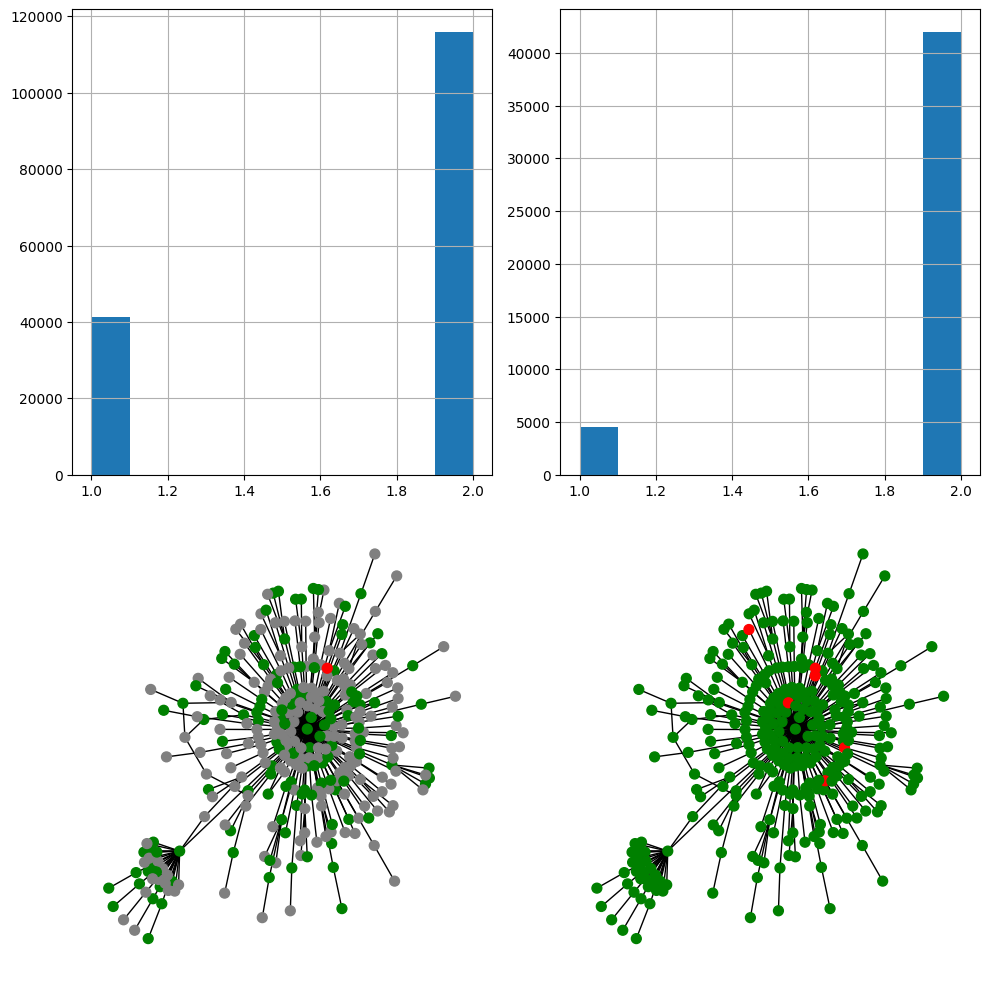

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)

X = features_unknown[tx_features+agg_features]
preds = pd.DataFrame(clf.predict(X),columns=['class'])
features_unknown = features_unknown[['txId']+tx_features+agg_features].join(preds)
features_unknown['class'] = features_unknown['class'].apply(lambda x: 2 if x==0 else 1)
features_classified = features_known.append(features_unknown)
features_unknown['class'].hist()
features_unknown['class'].value_counts(normalize=True) * 100

plt.subplot(2, 2, 2)
features_known['class'].hist()
features_known['class'].value_counts(normalize=True) * 100

import networkx as nx
plt.subplot(2, 2, 3)

transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

plt.subplot(2, 2, 4)
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features_classified[features_classified["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)


plt.tight_layout()
plt.show()

### Reg

<ipython-input-55-47174f61470c>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_classified = features_known.append(features_unknown)


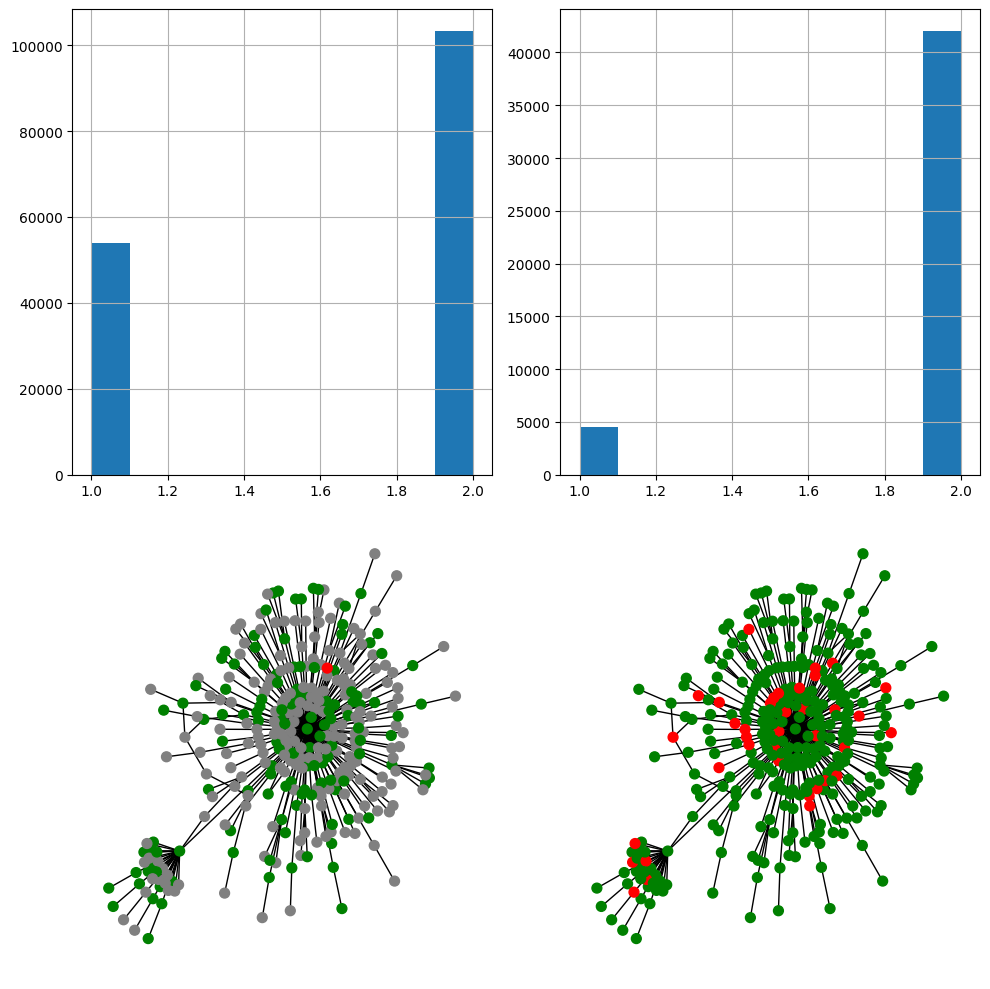

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  # 设置子图位置
    # 绘制第i张图片的代码
    # ...
X = features_unknown[tx_features+agg_features]
preds = pd.DataFrame(reg.predict(X),columns=['class'])
features_unknown = features_unknown[['txId']+tx_features+agg_features].join(preds)
features_unknown['class'] = features_unknown['class'].apply(lambda x: 2 if x==0 else 1)
features_classified = features_known.append(features_unknown)
features_unknown['class'].hist()
features_unknown['class'].value_counts(normalize=True) * 100

plt.subplot(2, 2, 2)  # 设置子图位置
features_known['class'].hist()
features_known['class'].value_counts(normalize=True) * 100

import networkx as nx
plt.subplot(2, 2, 3)  # 设置子图位置

transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

plt.subplot(2, 2, 4)  # 设置子图位置
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features_classified[features_classified["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)


plt.tight_layout()  # 调整子图的布局
plt.show()

### MLP

<ipython-input-56-2688b7f5de87>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_classified = features_known.append(features_unknown)


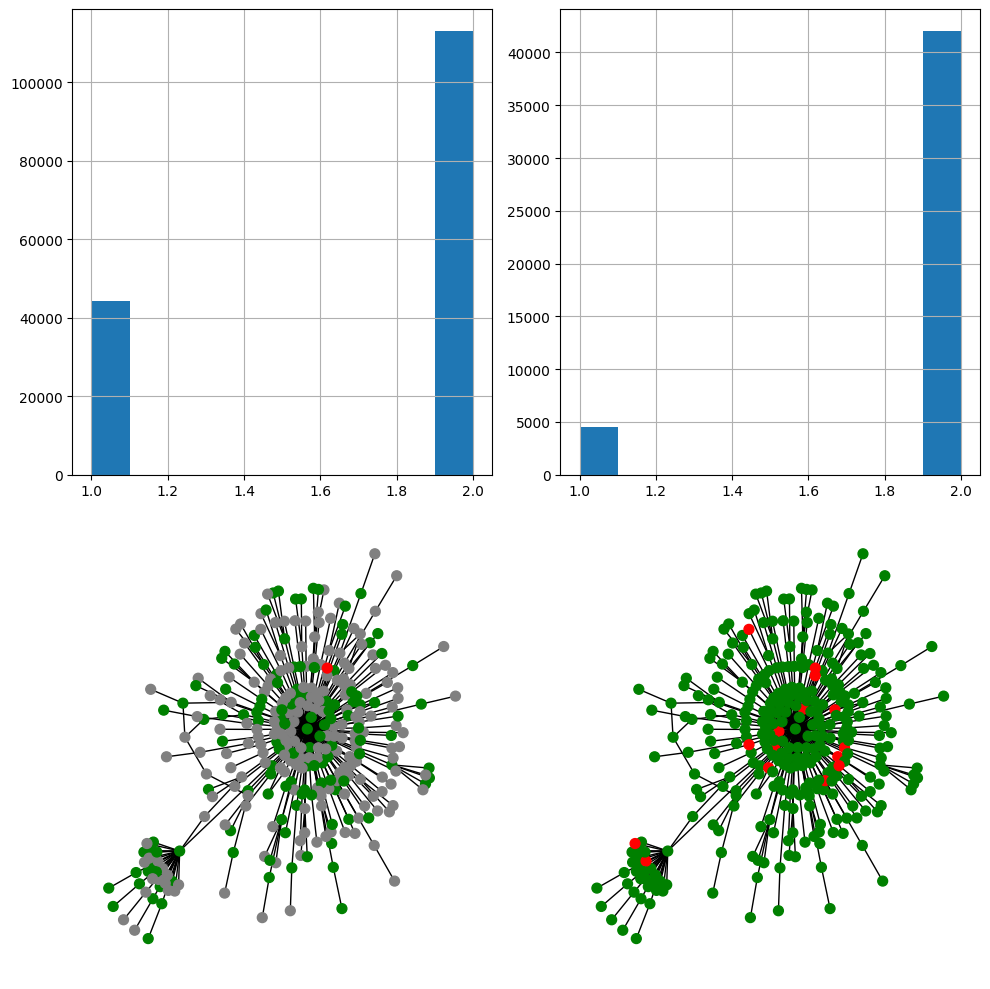

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  # 设置子图位置
    # 绘制第i张图片的代码
    # ...
X = features_unknown[tx_features+agg_features]
preds = pd.DataFrame(mlp.predict(X),columns=['class'])
features_unknown = features_unknown[['txId']+tx_features+agg_features].join(preds)
features_unknown['class'] = features_unknown['class'].apply(lambda x: 2 if x==0 else 1)
features_classified = features_known.append(features_unknown)
features_unknown['class'].hist()
features_unknown['class'].value_counts(normalize=True) * 100

plt.subplot(2, 2, 2)  # 设置子图位置
features_known['class'].hist()
features_known['class'].value_counts(normalize=True) * 100

import networkx as nx
plt.subplot(2, 2, 3)  # 设置子图位置

transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

plt.subplot(2, 2, 4)  # 设置子图位置
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features_classified[features_classified["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)


plt.tight_layout()  # 调整子图的布局
plt.show()

### **knb**

<ipython-input-57-e494d9331efc>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_classified = features_known.append(features_unknown)


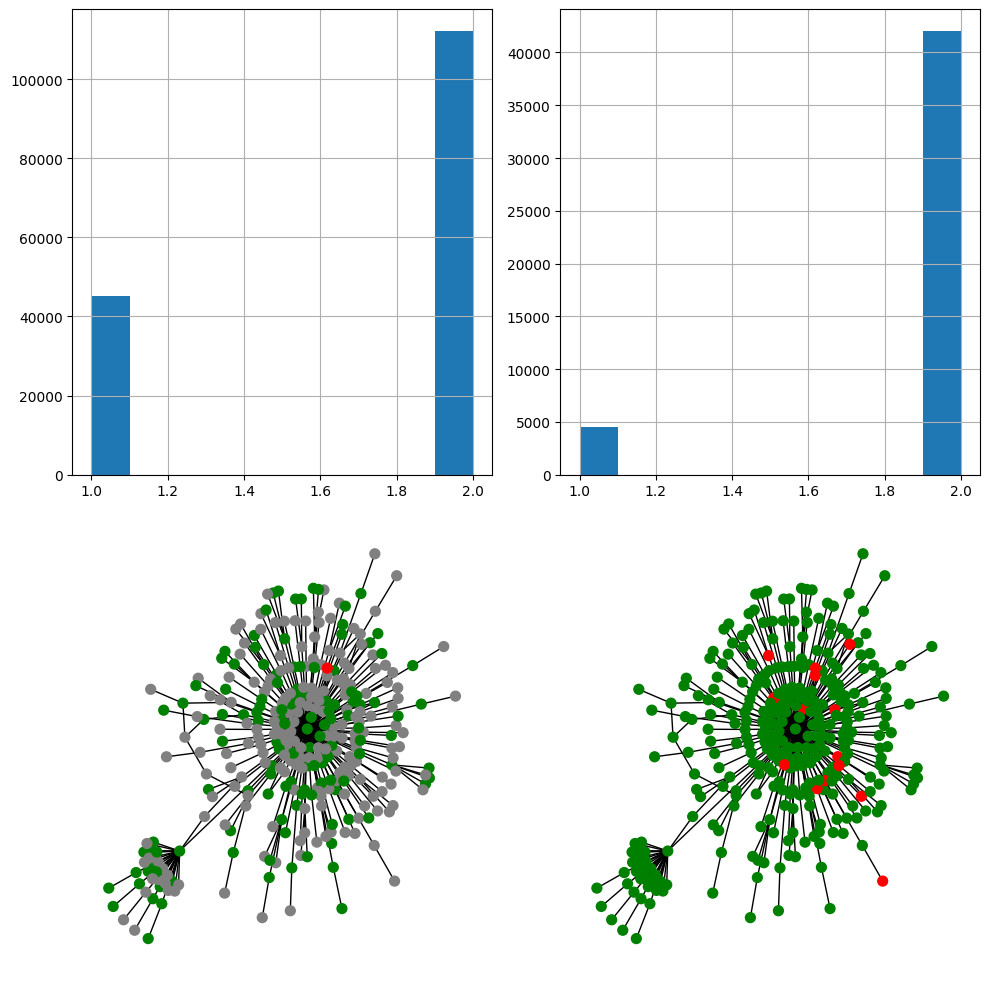

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  # 设置子图位置
    # 绘制第i张图片的代码
    # ...
X = features_unknown[tx_features+agg_features]
preds = pd.DataFrame(knb.predict(X),columns=['class'])
features_unknown = features_unknown[['txId']+tx_features+agg_features].join(preds)
features_unknown['class'] = features_unknown['class'].apply(lambda x: 2 if x==0 else 1)
features_classified = features_known.append(features_unknown)
features_unknown['class'].hist()
features_unknown['class'].value_counts(normalize=True) * 100

plt.subplot(2, 2, 2)  # 设置子图位置
features_known['class'].hist()
features_known['class'].value_counts(normalize=True) * 100

import networkx as nx
plt.subplot(2, 2, 3)  # 设置子图位置

transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

plt.subplot(2, 2, 4)  # 设置子图位置
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features_classified[features_classified["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)


plt.tight_layout()  # 调整子图的布局
plt.show()

### **svc**



<ipython-input-58-420814b0716c>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_classified = features_known.append(features_unknown)


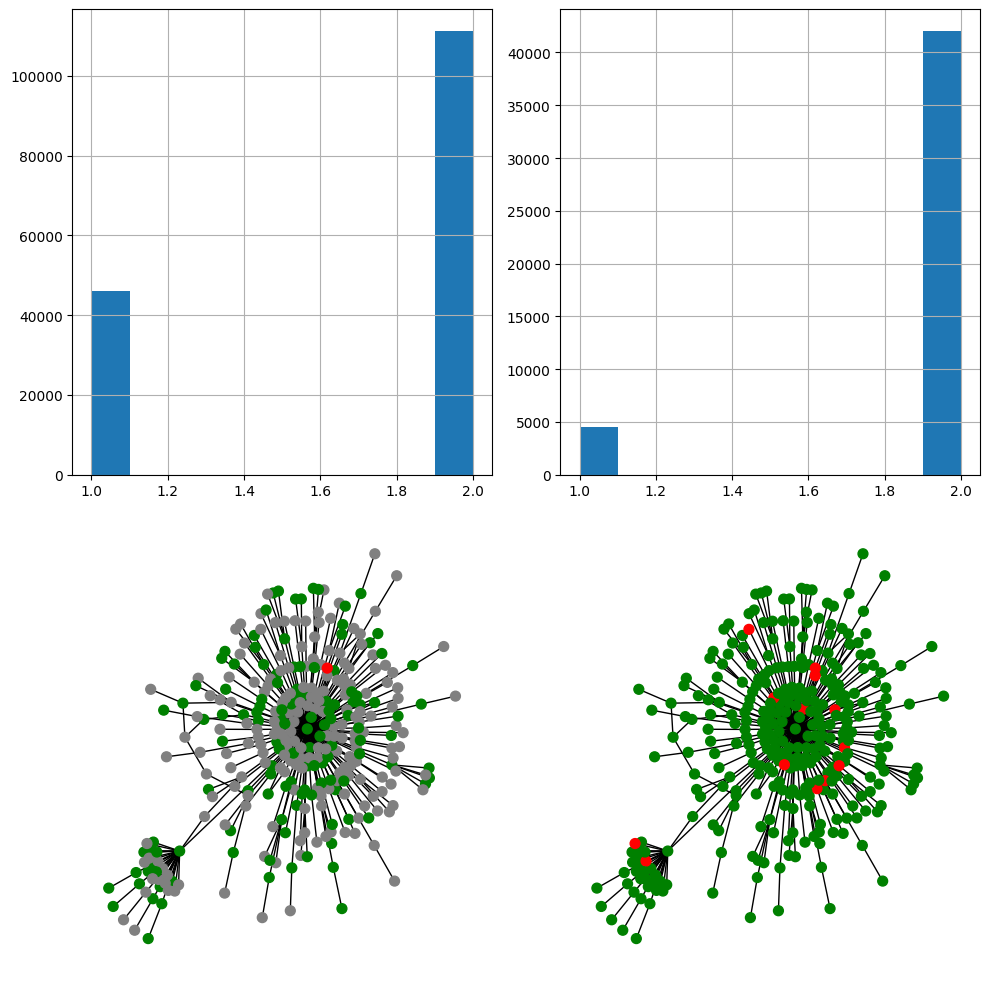

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  # 设置子图位置
    # 绘制第i张图片的代码
    # ...
X = features_unknown[tx_features+agg_features]
preds = pd.DataFrame(svc.predict(X),columns=['class'])
features_unknown = features_unknown[['txId']+tx_features+agg_features].join(preds)
features_unknown['class'] = features_unknown['class'].apply(lambda x: 2 if x==0 else 1)
features_classified = features_known.append(features_unknown)
features_unknown['class'].hist()
features_unknown['class'].value_counts(normalize=True) * 100

plt.subplot(2, 2, 2)  # 设置子图位置
features_known['class'].hist()
features_known['class'].value_counts(normalize=True) * 100

import networkx as nx
plt.subplot(2, 2, 3)  # 设置子图位置

transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

plt.subplot(2, 2, 4)  # 设置子图位置
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features_classified[features_classified["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)


plt.tight_layout()  # 调整子图的布局
plt.show()

### **dtc**


<ipython-input-59-6583d56420c2>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_classified = features_known.append(features_unknown)


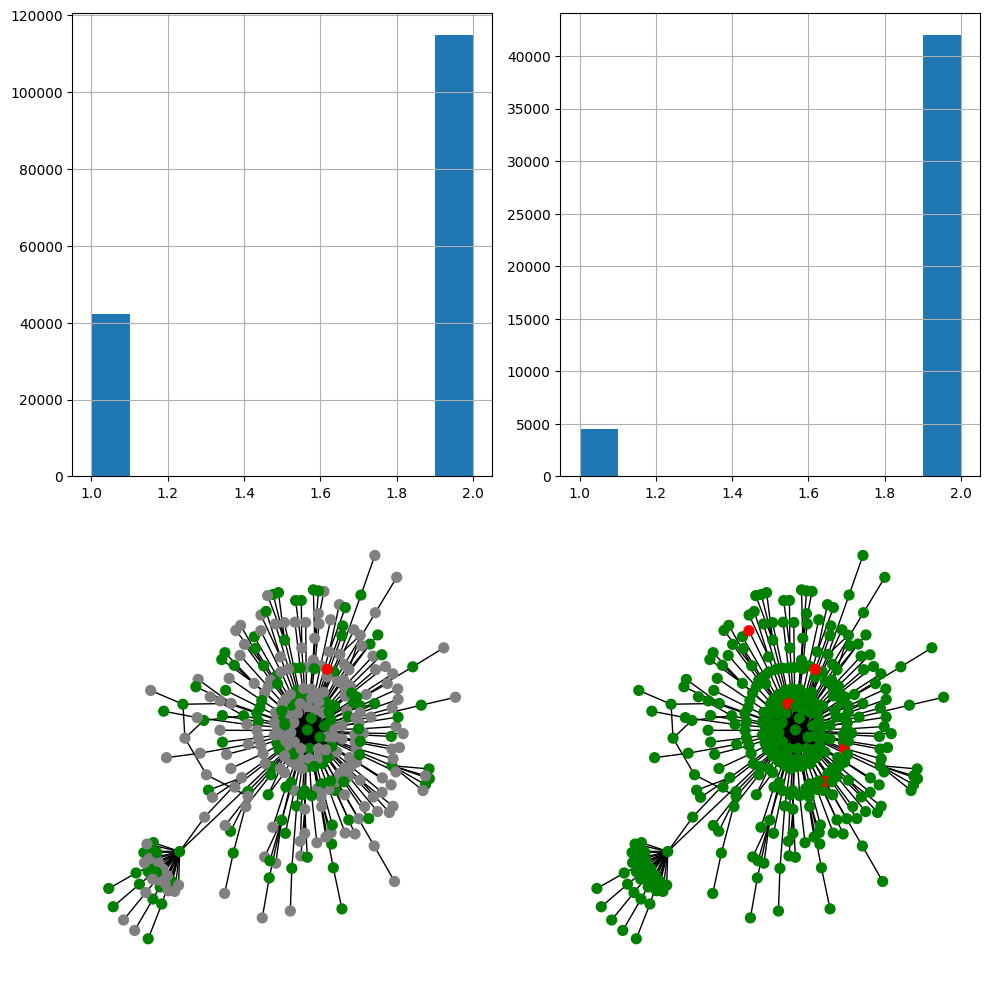

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  # 设置子图位置
    # 绘制第i张图片的代码
    # ...
X = features_unknown[tx_features+agg_features]
preds = pd.DataFrame(dtc.predict(X),columns=['class'])
features_unknown = features_unknown[['txId']+tx_features+agg_features].join(preds)
features_unknown['class'] = features_unknown['class'].apply(lambda x: 2 if x==0 else 1)
features_classified = features_known.append(features_unknown)
features_unknown['class'].hist()
features_unknown['class'].value_counts(normalize=True) * 100

plt.subplot(2, 2, 2)  # 设置子图位置
features_known['class'].hist()
features_known['class'].value_counts(normalize=True) * 100

import networkx as nx
plt.subplot(2, 2, 3)  # 设置子图位置

transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

plt.subplot(2, 2, 4)  # 设置子图位置
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features_classified[features_classified["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)


plt.tight_layout()  # 调整子图的布局
plt.show()

### **abc**



<ipython-input-60-b52b2c872f76>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_classified = features_known.append(features_unknown)


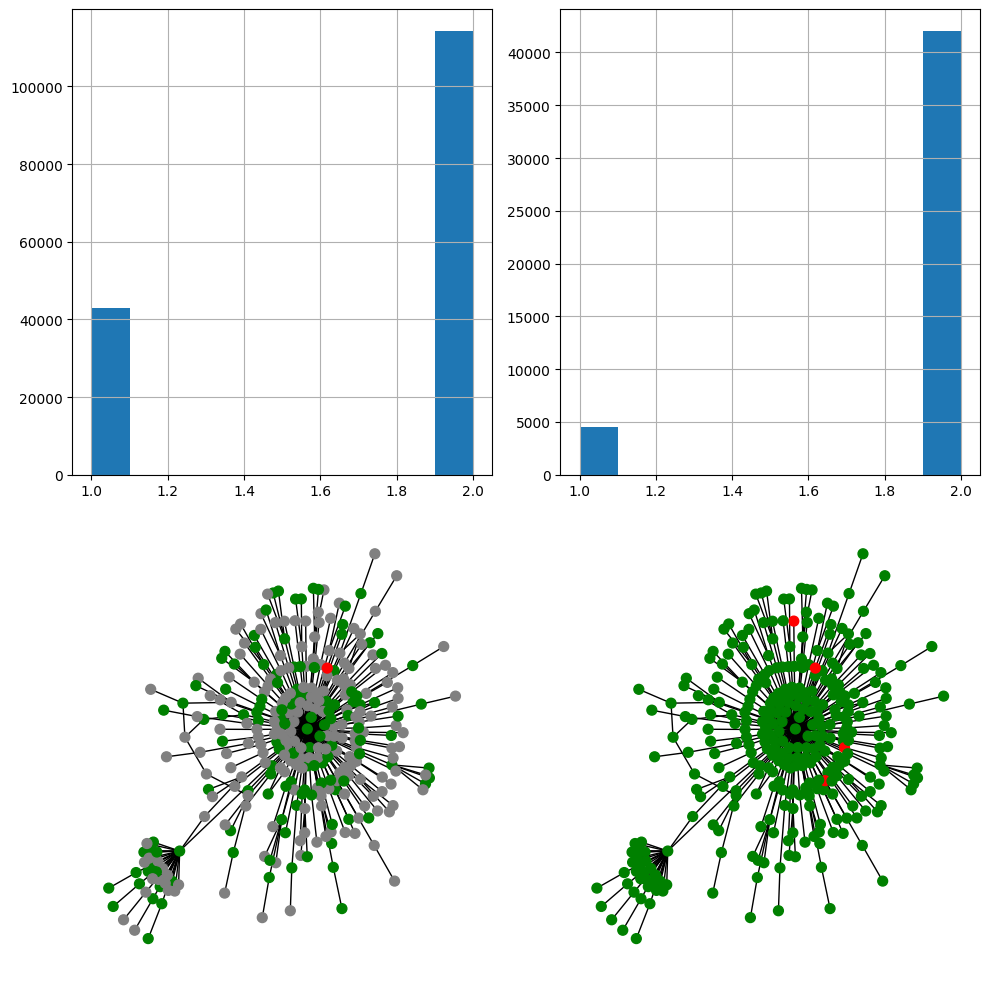

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  # 设置子图位置
    # 绘制第i张图片的代码
    # ...
X = features_unknown[tx_features+agg_features]
preds = pd.DataFrame(abc.predict(X),columns=['class'])
features_unknown = features_unknown[['txId']+tx_features+agg_features].join(preds)
features_unknown['class'] = features_unknown['class'].apply(lambda x: 2 if x==0 else 1)
features_classified = features_known.append(features_unknown)
features_unknown['class'].hist()
features_unknown['class'].value_counts(normalize=True) * 100

plt.subplot(2, 2, 2)  # 设置子图位置
features_known['class'].hist()
features_known['class'].value_counts(normalize=True) * 100

import networkx as nx
plt.subplot(2, 2, 3)  # 设置子图位置

transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

plt.subplot(2, 2, 4)  # 设置子图位置
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features_classified[features_classified["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)


plt.tight_layout()  # 调整子图的布局
plt.show()

### **gbm**


<ipython-input-61-a6d8393cdcb2>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_classified = features_known.append(features_unknown)


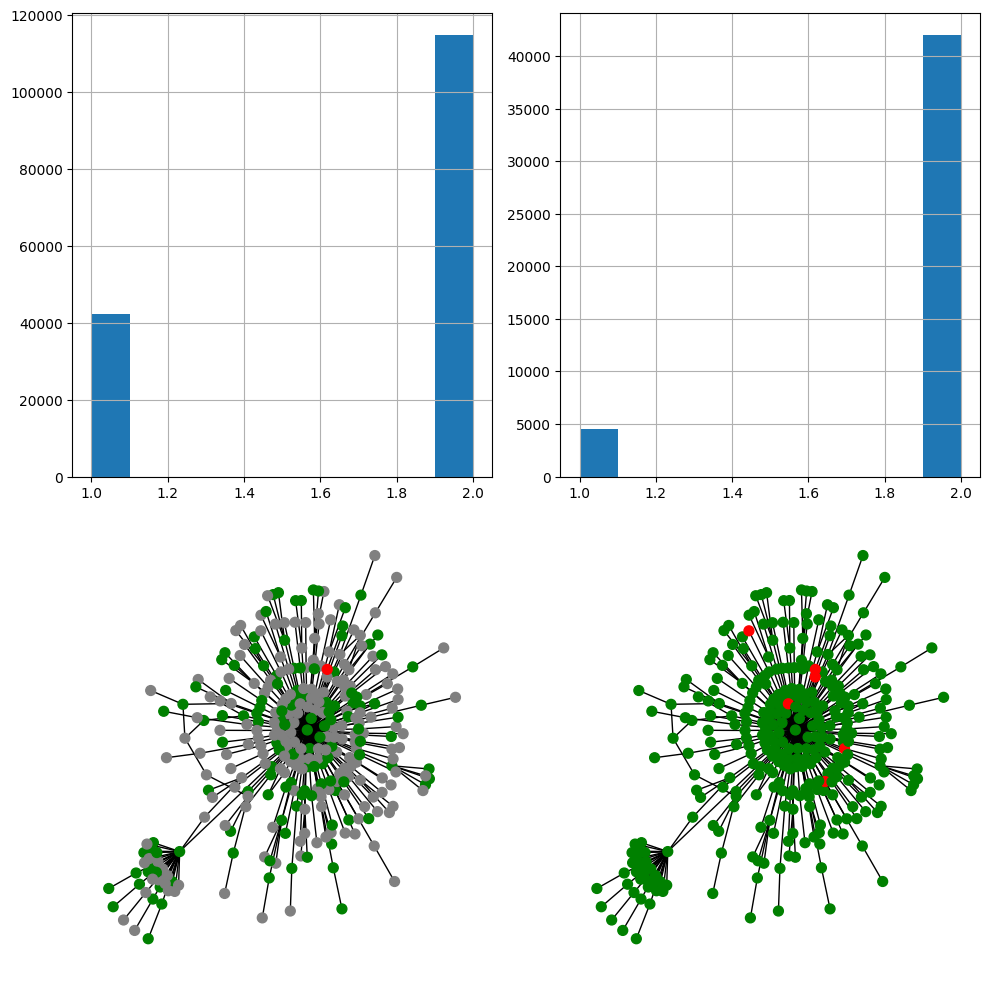

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)  # 设置子图位置
    # 绘制第i张图片的代码
    # ...
X = features_unknown[tx_features+agg_features]
preds = pd.DataFrame(gbm.predict(X),columns=['class'])
features_unknown = features_unknown[['txId']+tx_features+agg_features].join(preds)
features_unknown['class'] = features_unknown['class'].apply(lambda x: 2 if x==0 else 1)
features_classified = features_known.append(features_unknown)
features_unknown['class'].hist()
features_unknown['class'].value_counts(normalize=True) * 100

plt.subplot(2, 2, 2)  # 设置子图位置
features_known['class'].hist()
features_known['class'].value_counts(normalize=True) * 100

import networkx as nx
plt.subplot(2, 2, 3)  # 设置子图位置

transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

plt.subplot(2, 2, 4)  # 设置子图位置
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features_classified[features_classified["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)


plt.tight_layout()  # 调整子图的布局
plt.show()

Exploring the distribution of classes in the unknown part. We see there is a big change from the 9 to 1 in the known part to the 73 to 26 in the classified part of the network.
This is because the proposal of this paper is based around the idea of training with the past for classifiying the future.
This choice is controversial, but for comparative purpose it is mantained troughout the following study.

## Using the tracker function

### find a connected network we intend to inspect

In [62]:
# deep_levels = 10
# keep = {}
# tries = 0
# minimum_nodes = 160

# while(len(keep) < minimum_nodes):
#   seed = get_random_illicit(features)
#   keep,edgeList,counter,complete = tracker(deep_levels,seed,edges)
#   tries = tries + 1

# print("is the graph complete: ",complete)
# print("iterations-> ",counter)
# print("transactions found->",len(keep))
# print("seed : ",seed)
# print("seed tried:", tries)
# print("transactions : \n")



is the graph complete:  True
iterations->  186
transactions found-> 184
seed :  15439
seed tried: 2717
transactions : 



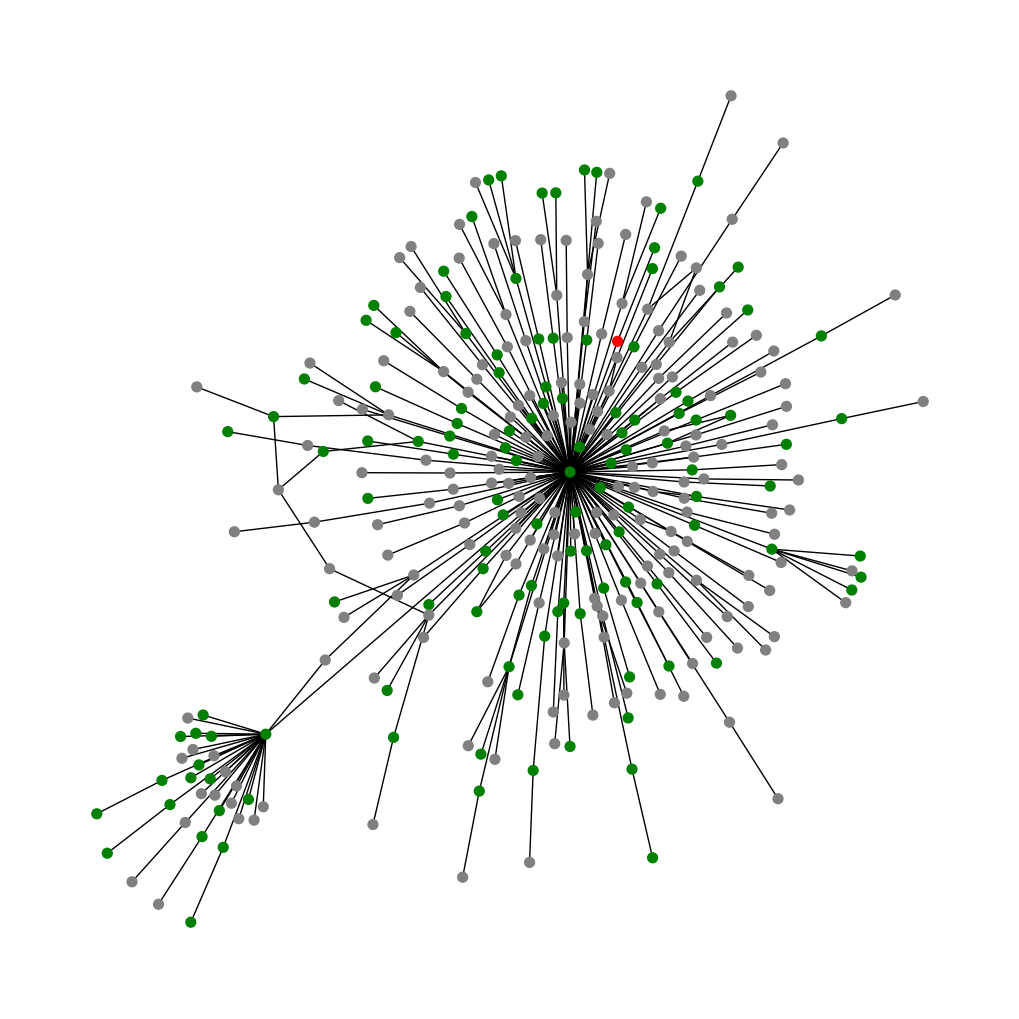

In [63]:
plt.figure(figsize=(10, 10))
import networkx as nx
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
transaction_type = features[features["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

### check the classified results

<ipython-input-64-a9bc85bf990c>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_classified = features_known.append(features_unknown)


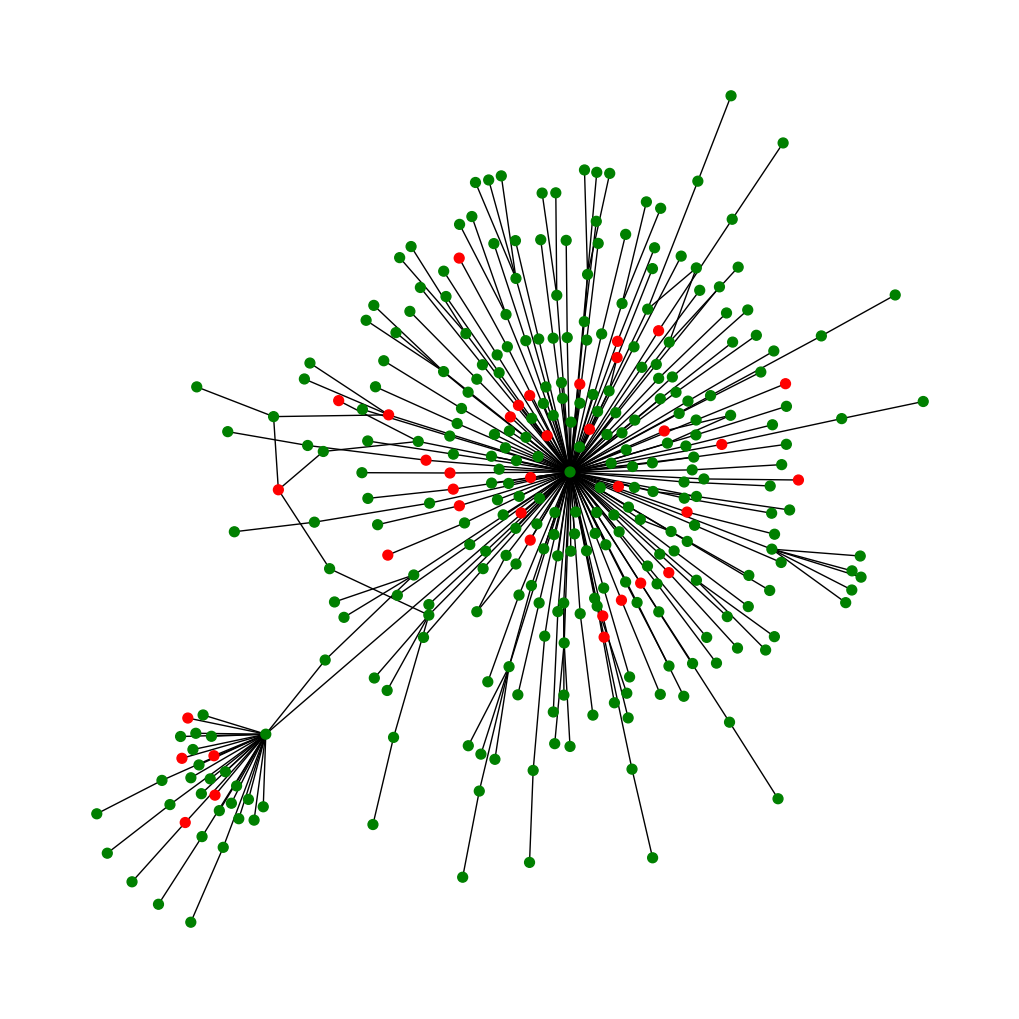

In [64]:
plt.figure(figsize=(10, 10))
import networkx as nx
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')


X = features_unknown[tx_features+agg_features]
preds = pd.DataFrame(reg.predict(X),columns=['class'])
features_unknown = features_unknown[['txId']+tx_features+agg_features].join(preds)
features_unknown['class'] = features_unknown['class'].apply(lambda x: 2 if x==0 else 1)
features_classified = features_known.append(features_unknown)
transaction_type = features_classified[features_classified["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

<ipython-input-65-7c8e3d372212>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_classified = features_known.append(features_unknown)
<ipython-input-65-7c8e3d372212>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nodes_with_class_1 = features_classified[features_classified["txId"].isin(transaction_graph.nodes)][features_classified["class"] == 1]


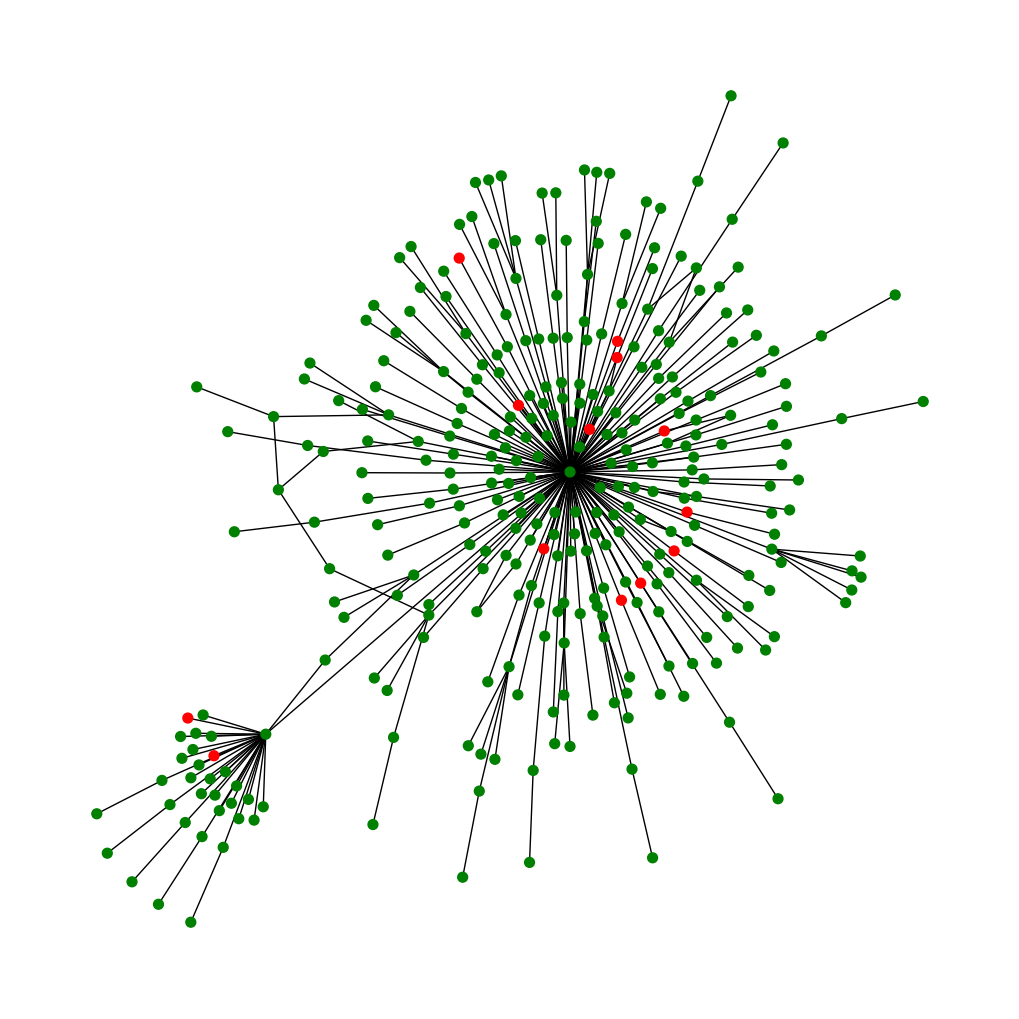

In [65]:
plt.figure(figsize=(10, 10))
import networkx as nx
transaction_graph = nx.from_pandas_edgelist(edgeList,source='txId1', target='txId2')
# 创建图形对象
transaction_graph = nx.from_pandas_edgelist(edgeList, source='txId1', target='txId2')


X = features_unknown[tx_features+agg_features]
preds = pd.DataFrame(svc.predict(X),columns=['class'])
features_unknown = features_unknown[['txId']+tx_features+agg_features].join(preds)
features_unknown['class'] = features_unknown['class'].apply(lambda x: 2 if x==0 else 1)
features_classified = features_known.append(features_unknown)

# 获取具有 class 为 1 的节点
# nodes_with_class_1 = features_classified[features_classified["txId"].isin(transaction_graph.nodes)][features_classified["class"] == 1]

# # 根据具有 class 1 的节点的相邻节点设置类别为 1
# for node in nodes_with_class_1["txId"]:
#     neighbors = transaction_graph.neighbors(node)
#     for neighbor in neighbors:
#         transaction_graph.nodes[neighbor]["class"] = 1

transaction_type = features_classified[features_classified["txId"].isin(list(transaction_graph.nodes))]["class"].sort_index()
transaction_type = transaction_type.apply(lambda x: 'gray' if x == 0 else x)
transaction_type = transaction_type.apply(lambda x: 'red' if x == 1 else x)
transaction_type = transaction_type.apply(lambda x: 'green' if x == 2 else x)
my_pos = nx.spring_layout(transaction_graph, seed = 100)
nx.draw(transaction_graph,node_size=50, pos=my_pos,node_color=list(transaction_type),width=1)

The following table contains all the results obtained with the classifiers above. Training on this kind of dataset, driven by time rather than class distribution, can produce different results in different training session.

In [66]:
compare

,model,Precision,Recall,F1 Score,M.A F1 Score
0,Random Forest Classifier (tx),0.981,0.854,0.913,0.985
1,Random Forest Classifier (tx + agg),0.994,0.888,0.938,0.989
2,Logistic Regression (tx),0.910,0.725,0.807,0.967
3,Logistic Regression (tx + agg),0.848,0.791,0.819,0.967
4,MLP (tx),0.883,0.752,0.813,0.967
5,MLP (tx + agg),0.940,0.790,0.859,0.975
6,KNeighbotsClassifier (tx),0.941,0.821,0.877,0.978
7,KNeighbotsClassifier (tx + agg),0.925,0.816,0.867,0.976
8,SVC (tx),0.843,0.753,0.796,0.963
9,SVC (tx + agg),0.918,0.776,0.841,0.972


In [67]:
labels = compare['model'].to_numpy()

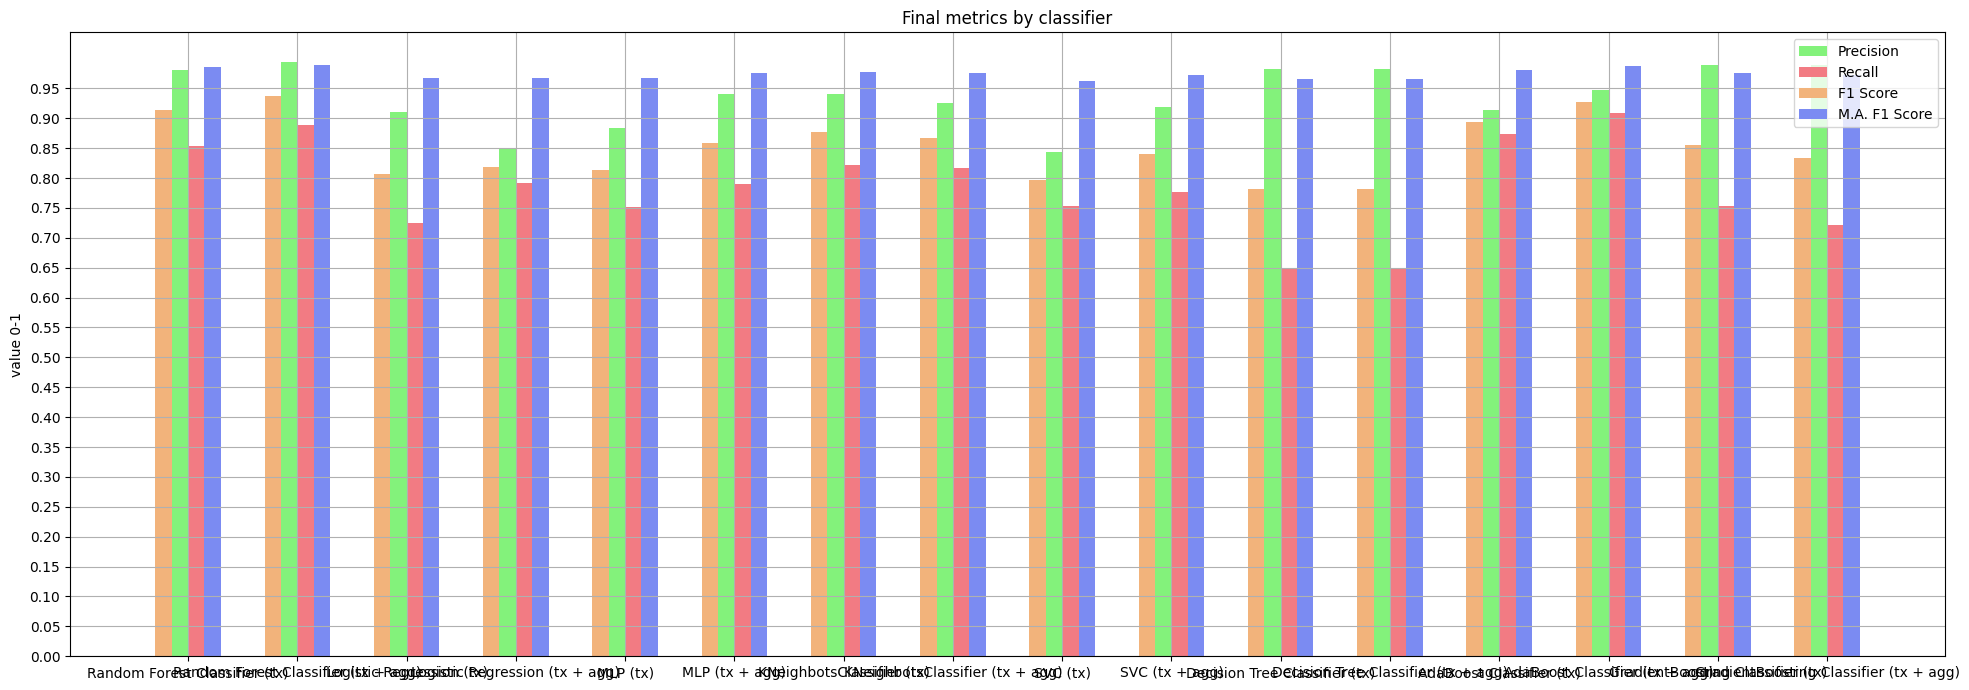

In [68]:


precision = compare['Precision'].to_numpy()
recall = compare['Recall'].to_numpy()
f1 = compare['F1 Score'].to_numpy()
maf1 = compare['M.A F1 Score'].to_numpy()

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars
fig, ax = plt.subplots(figsize=(20, 7))
prec_rects = ax.bar(x - width/2, precision, width, label='Precision',color='#83f27b')
rec_rects = ax.bar(x + width/2, recall, width, label='Recall',color='#f27b83')
f1_rects = ax.bar(x - (3/2)*width, f1, width, label='F1 Score',color='#f2b37b')
MAf1_rects = ax.bar(x + (3/2)*width, maf1, width, label='M.A. F1 Score',color='#7b8bf2')

ax.set_ylabel('value 0-1')
ax.set_title('Final metrics by classifier')
ax.set_xticks(np.arange(0,len(labels),1))
ax.set_yticks(np.arange(0,1,0.05))
ax.set_xticklabels(labels=labels)
ax.legend()

plt.grid(True)
fig.tight_layout()
plt.show()

We can see in the  following table that the results obtained are in-line with the paper's result.

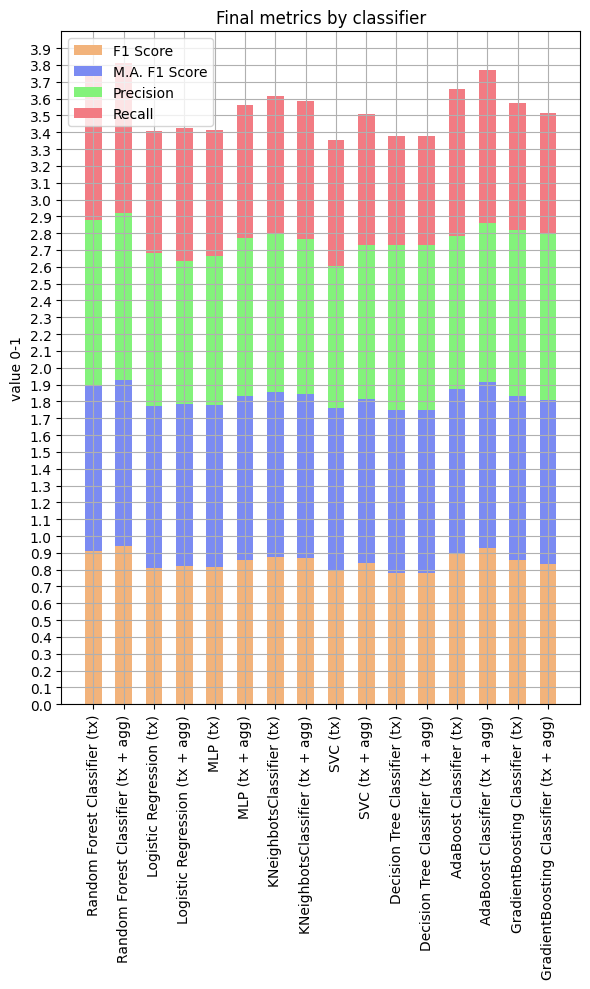

In [69]:


precision = compare['Precision'].to_numpy()
recall = compare['Recall'].to_numpy()
f1 = compare['F1 Score'].to_numpy()
maf1 = compare['M.A F1 Score'].to_numpy()

x = np.arange(len(labels))  # the label locations
width = 0.55  # the width of the bars
fig, ax = plt.subplots(figsize=(6, 10))
f1_rects = ax.bar(x, f1, width, label='F1 Score',color='#f2b37b')
MAf1_rects = ax.bar(x , maf1, width, label='M.A. F1 Score',color='#7b8bf2',bottom=f1)
prec_rects = ax.bar(x, precision, width, label='Precision',color='#83f27b',bottom=maf1 + f1)
rec_rects = ax.bar(x, recall, width, label='Recall',color='#f27b83',bottom=maf1 + f1 + precision)

ax.set_ylabel('value 0-1')
ax.set_title('Final metrics by classifier')
ax.set_xticks(np.arange(0,len(labels),1))
ax.set_yticks(np.arange(0,4,0.1))
ax.set_xticklabels(labels=labels)
ax.legend()

plt.xticks(rotation=90)
plt.grid(True)
fig.tight_layout()
plt.show()

Save the results for later use

In [70]:
compare.to_csv("/content/elliptic_bitcoin_dataset_cont/1_result_elliptic.csv")